In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
from collections import OrderedDict
from collections import defaultdict
from random import randrange
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

import respy as rp
from respy.pre_processing.model_processing import process_params_and_options

from python.auxiliary import *

# Simulated Method of Moments estimation

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Observed-Data" data-toc-modified-id="Observed-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Observed Data</a></span></li><li><span><a href="#Data-Moments" data-toc-modified-id="Data-Moments-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data Moments</a></span></li><li><span><a href="#Weighting-Matrix" data-toc-modified-id="Weighting-Matrix-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Weighting-Matrix</a></span></li><li><span><a href="#Criterion-Function" data-toc-modified-id="Criterion-Function-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Criterion Function</a></span></li><li><span><a href="#Estimation-Exercise" data-toc-modified-id="Estimation-Exercise-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Estimation Exercise</a></span><ul class="toc-item"><li><span><a href="#Estimation-for-one-parameter" data-toc-modified-id="Estimation-for-one-parameter-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Estimation for one parameter</a></span><ul class="toc-item"><li><span><a href="#Simulated-Moments" data-toc-modified-id="Simulated-Moments-5.1.1"><span class="toc-item-num">5.1.1&nbsp;&nbsp;</span>Simulated Moments</a></span></li><li><span><a href="#Optimization-procedure" data-toc-modified-id="Optimization-procedure-5.1.2"><span class="toc-item-num">5.1.2&nbsp;&nbsp;</span>Optimization procedure</a></span></li></ul></li><li><span><a href="#Estimation-of-multiple-parameters" data-toc-modified-id="Estimation-of-multiple-parameters-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Estimation of multiple parameters</a></span></li><li><span><a href="#Changing-the-Simulation-Seed" data-toc-modified-id="Changing-the-Simulation-Seed-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Changing the Simulation Seed</a></span></li><li><span><a href="#Fixing-one-parameter-at-the-wrong-value" data-toc-modified-id="Fixing-one-parameter-at-the-wrong-value-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Fixing one parameter at the wrong value</a></span></li><li><span><a href="#Retrieving-the-true-parameter-vector" data-toc-modified-id="Retrieving-the-true-parameter-vector-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Retrieving the true parameter vector</a></span></li></ul></li></ul></div>

To Do:
 - [ ] Add Weighting Matrix (Sec. 3)
 - [ ] Add explanations for criterion function (Sec. 4)
 - [ ] Add wrapper for criterion function (Sec. 4)
 - [ ] Compare simulated moments and observed moments graphically
 - [x] Rework code for plots to hide specifications in auxiliary file (Sec. 4)
 - [x] Remove custom formatting from plots (Sec. 4)
 - [ ] Add outline to estimation (Sec. 5)
 - [x] Edit part on changing the simulation seed (Sec. 5)
 - [ ] Add text to sections on fixing and retrieving parameters (Sec. 5.2-5.5)
 - [ ] Add references


##  Observed Data

Our generate our model and data using [respy](https://respy.readthedocs.io/en/latest/) and a simple Robinson Crusoe model. In this simple, the agent, Robinson Crusoe, in each time period decides between two choice options: working (i.e. going fishing) or spending time in the hammock. 

In [2]:
#options = yaml.safe_load(open(os.environ["ROBINSON_SPEC"] + '/robinson.yaml', 'r'))

#params_true = pd.read_csv(open(os.environ["ROBINSON_SPEC"] + '/robinson.csv', 'r'))
#params_true.set_index(["category", "name"], inplace=True)

#simulate = rp.get_simulate_func(params_true, options)
#data_obs = simulate(params_true)

In [3]:
params_true, options, data_obs = rp.get_example_model("robinson", with_data=True)

Let's take a look at the model specifications.

In [4]:
params_true 

value
category       name                       
delta          delta                 0.950
wage_fishing   exp_fishing           0.070
nonpec_fishing constant             -0.100
nonpec_hammock constant              1.046
shocks_sdcorr  sd_fishing            0.010
               sd_hammock            0.010
               corr_hammock_fishing  0.000

In [5]:
options

{'estimation_draws': 100,
 'estimation_seed': 100,
 'estimation_tau': 0.001,
 'interpolation_points': -1,
 'n_periods': 5,
 'simulation_agents': 1000,
 'simulation_seed': 132,
 'solution_draws': 100,
 'solution_seed': 456,
 'covariates': {'constant': '1'}}

In [6]:
data_obs.head(10)

,Identifier,Period,Choice,Wage,Experience_Fishing,Type,Nonpecuniary_Reward_Fishing,Nonpecuniary_Reward_Hammock,Wage_Fishing,Flow_Utility_Fishing,Flow_Utility_Hammock,Value_Function_Fishing,Value_Function_Hammock,Shock_Reward_Fishing,Shock_Reward_Hammock,Discount_Rate
0,0,0,fishing,1.007197,0,0,-0.1,1.046,1.000000,0.907197,1.056305,4.747093,4.744600,1.007197,0.010305,0.95
1,0,1,fishing,1.082581,1,0,-0.1,1.046,1.072508,0.982581,1.046042,4.050283,3.892430,1.009392,0.000042,0.95
2,0,2,fishing,1.163836,2,0,-0.1,1.046,1.150274,1.063836,1.053231,3.244500,3.073945,1.011790,0.007231,0.95
3,0,3,fishing,1.239123,3,0,-0.1,1.046,1.233678,1.139123,1.048698,2.301106,2.125701,1.004414,0.002698,0.95
4,0,4,fishing,1.292003,4,0,-0.1,1.046,1.323130,1.192003,1.030870,1.192003,1.030870,0.976475,-0.015130,0.95
5,1,0,hammock,NaN,0,0,-0.1,1.046,1.000000,0.881015,1.056596,4.720911,4.744891,0.981015,0.010596,0.95
6,1,1,hammock,NaN,0,0,-0.1,1.046,1.000000,0.921590,1.039141,3.767979,3.877250,1.021590,-0.006859,0.95
7,1,2,hammock,NaN,0,0,-0.1,1.046,1.000000,0.899238,1.052078,2.839895,2.992736,0.999238,0.006078,0.95
8,1,3,hammock,NaN,0,0,-0.1,1.046,1.000000,0.893793,1.038037,1.889801,2.034046,0.993793,-0.007963,0.95
9,1,4,hammock,NaN,0,0,-0.1,1.046,1.000000,0.912283,1.052177,0.912283,1.052177,1.012283,0.006177,0.95


## Data Moments

For the setup of the estimation we first have to choose a set of moments that we will use to match the observed data and the simulated model. For this model we include two sets of moments: 

1. The first set are Robinson's **choice probabilities** (choice probabilities here refers to the share of agents that have chosen a specific option) for each period. 
2. The second set are moments that characterize the **wage distribution** for each period, i.e. the mean of the wage of all agents that have chosen fishing in a given period and the standard deviation of the wages. 

In addition to the data, we need the complete set of potential choice options for Robinson. Respy lets us extract them from the model parameters and options.

In [7]:
optim_paras = process_params_and_options(params_true, options)[0]
choice_options_robinson = optim_paras["choices"].keys()

Using the observed data and set of choice options, we can calculate the moments.

In [8]:
# Use a function to calculate the data moments.
moments_obs = get_moments(data_obs, choice_options_robinson)
print('Choice Probabilities')
print(moments_obs['Choice Probabilities'])
print('\n Wage Distribution')
print(moments_obs['Wage Distribution'])

Choice Probabilities
{0: [0.631, 0.369], 1: [0.631, 0.369], 2: [0.631, 0.369], 3: [0.631, 0.369], 4: [0.631, 0.369]}

 Wage Distribution
{0: [1.0037950532864608, 0.009222735533113452], 1: [1.0724623646069125, 0.010885774459361966], 2: [1.1506433910875764, 0.01165976621540699], 3: [1.2325871778674606, 0.01188724268886421], 4: [1.3230636324871103, 0.012512007111785479]}


## Weighting-Matrix

Next we specify a weighting matrix.

In [9]:
# I use the identity matrix for now.
num_moments = options['n_periods']*len(choice_options_robinson)*2
identity_matrix = np.eye(num_moments)
print(identity_matrix)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.

## Criterion Function 

Criterion function at the true parameter vector.

In [10]:
fval = evaluate(params_true, options, identity_matrix, moments_obs, choice_options_robinson)
fval

0.0

We can plot the criterion function to examine its behavior around the minimum in more detail. The plots below show the criterion function at varying values of all parameters in the the paramter vector.

In [11]:
params_true

value
category       name                       
delta          delta                 0.950
wage_fishing   exp_fishing           0.070
nonpec_fishing constant             -0.100
nonpec_hammock constant              1.046
shocks_sdcorr  sd_fishing            0.010
               sd_hammock            0.010
               corr_hammock_fishing  0.000

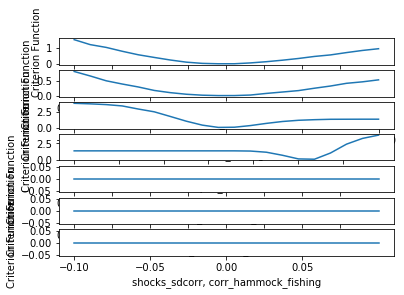

In [44]:
criterion_args = [options, identity_matrix, moments_obs, choice_options_robinson]
plot_criterion_params(params_true, criterion_args)

This depiction conceals the fact, that the criterion function is not a smooth function of our parameter values. We can reveal this property if we 'zoom into' the function far enough. The plots below show the criterion function for varying values of delta around the true minimum value of 0.95. We can see that the function exhibits small plateaus and is thus not completely smooth. 

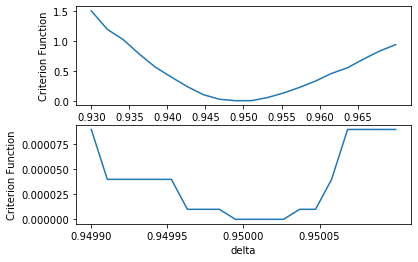

In [45]:
criterion_args = [options, identity_matrix, moments_obs, choice_options_robinson]
plot_criterion_detail(params_true, criterion_args)

##  Estimation Exercise

In the following we will conduct a simulation exercise to estimate the parameter vector using our criterion function and weighting matrix for a parameter vector that differs from the true parameters. Additionally, we will explore how the criterion function behaves if we change the simulation seed or misspecify the constraints by fixing parameters at the wrong values.

### Estimation for one parameter

For now, our candidate parameter vector will just differ in *delta* from the true parameters.

In [14]:
params_cand = params_true.copy()
params_cand.loc['delta','value'] = 0.93

#### Simulated Moments

We can now use our model to simulate data using the candidate parameter vector. We can see that the choice probabilities and wage distribution differ from the moments of the observed dataset.

In [15]:
params = params_cand.copy()
simulate = rp.get_simulate_func(params, options)
df_sim = simulate(params)
moments_sim = get_moments(df_sim, choice_options_robinson)

print('Choice Probabilities')
print(moments_sim['Choice Probabilities'])
print('\n Wage Distribution')
print(moments_sim['Wage Distribution'])

Choice Probabilities
{0: [0.244, 0.756], 1: [0.244, 0.756], 2: [0.244, 0.756], 3: [0.244, 0.756], 4: [0.244, 0.756]}

 Wage Distribution
{0: [1.0095149927160547, 0.008198290003548022], 1: [1.0728957195893678, 0.010514385733230281], 2: [1.1515521441487266, 0.011934344072283899], 3: [1.2330302273612044, 0.011737002476584076], 4: [1.3217938871844948, 0.013266040322672396]}


We can see that the criterion function value for the candidate parameter vector is not zero.

In [16]:
fval = evaluate(params_cand, options, identity_matrix, moments_obs, choice_options_robinson)
fval

1.4977273938311657

#### Optimization procedure

We will now use an optimization procedure to retrieve the true parameter vector. For the optimization we can use [estimagic](https://estimagic.readthedocs.io/en/latest/index.html). For our optimization procedure we need estimagic's `minimize` function.



In [17]:
from estimagic.optimization.optimize import minimize

We have verified above that the criterion function gives a value of 0 for the true parameter vector. Before we try different parameter specifications, we can check whether an optimizer recognizes the true vector as the minimum of our criterion function.

As the code below shows, the optimization algorithm recognizes the true parameter vector as the minimum of the criterion function as it returns a function value of 0 and the true parameter values.

In [18]:
rslt = minimize(criterion=evaluate,
                params=params_true,
                algorithm="nlopt_bobyqa",
                criterion_args=(options, identity_matrix, moments_obs, choice_options_robinson),
               )
rslt[0]

{'fun': 0.0, 'internal_x': [0.95, 0.07, -0.1, 1.046, 0.01, 0.01, 0.0]}

##### Upper and Lower Bounds

We can help the optimizer by specifying bounds for the parameters. Since we know the true parameters in the case of this model, we can just pick upper and lower bounds that are fairly close to the true values of the parameters to aid the optimizer in the search for the optimum. By default, the upper and lower bounds are set to $\infty$ and $-\infty$, so specifying upper and lower bounds substantially reduces the range of parameter values that the optimizer can potentially cover.

For optimization with estimagic, we can specify bounds by adding the columns *'lower'* and *'upper'* to the dataframe that contains the parameter values.

In [19]:
# Lower and upper bound for parameters
params_cand['lower'] = [0.89, 0.066, -0.11, 1.04, 0, 0, 0]
params_cand['upper'] = [0.98, 0.072, -0.095, 1.055, 0.1, 0.1, 0.1]
params_cand

value  lower  upper
category       name                                     
delta          delta                 0.930  0.890  0.980
wage_fishing   exp_fishing           0.070  0.066  0.072
nonpec_fishing constant             -0.100 -0.110 -0.095
nonpec_hammock constant              1.046  1.040  1.055
shocks_sdcorr  sd_fishing            0.010  0.000  0.100
               sd_hammock            0.010  0.000  0.100
               corr_hammock_fishing  0.000  0.000  0.100

##### Constraints
In addition to specifying bounds we can also need to specify constraints for the optimization. Respy's example models already come with a predefined set of constraints.

In [20]:
#constr = rp.get_parameter_constraints("robinson")
#constr

Additionally we for now hold all other parameters fixed to aid the optimizer in finding the optimal value of delta.

In [21]:
"""constr += [
    #{"loc": "delta", "type": "fixed", "value": 0.95},
    {"loc": "wage_fishing", "type": "fixed", "value": 0.07},
    {"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},
    {"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},
    {"loc": "shocks_sdcorr", "type": "fixed"},

]
constr"""

'constr += [\n    #{"loc": "delta", "type": "fixed", "value": 0.95},\n    {"loc": "wage_fishing", "type": "fixed", "value": 0.07},\n    {"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},\n    {"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},\n    {"loc": "shocks_sdcorr", "type": "fixed"},\n\n]\nconstr'

In [22]:
constr = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    #{"loc": "delta", "type": "fixed", "value": 0.95},
    {"loc": "wage_fishing", "type": "fixed", "value": 0.07},
    {"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},     
    {"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},
    {"loc": ("shocks_sdcorr","sd_fishing"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","sd_hammock"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","corr_hammock_fishing"), "type": "fixed", "value": 0},  
]

##### Optimize

In [23]:
rslt = minimize(criterion=evaluate,
                params=params_cand,
                algorithm="nlopt_bobyqa",
                constraints=constr,
                criterion_args=(options,identity_matrix, moments_obs, choice_options_robinson),
               )
rslt[0]

{'fun': 0.0, 'internal_x': [0.950025]}

### Estimation of multiple parameters

In [24]:
params_multi = params_cand.copy()
params_multi.loc['delta', 'value'] = 0.96
params_multi.loc['wage_fishing','value'] = 0.0705
params_multi.loc[('nonpec_fishing','value')] = -0.097
params_multi.loc[('nonpec_hammock','value')] = 1.049
params_multi.loc[("shocks_sdcorr","sd_fishing"),"value"] = 0.01
params_multi.loc[("shocks_sdcorr","sd_hammock"),"value"] = 0.01
params_multi.loc[("shocks_sdcorr","corr_hammock_fishing"), "value"] = 0

In [25]:
#Checking choice porportions for given
simulate = rp.get_simulate_func(params_multi, options)
data_sim = simulate(params_multi)
data_sim.Choice.value_counts()

fishing    4555
hammock     445
Name: Choice, dtype: int64

In [26]:
params_multi

value  lower  upper
category       name                                      
delta          delta                 0.9600  0.890  0.980
wage_fishing   exp_fishing           0.0705  0.066  0.072
nonpec_fishing constant             -0.0970 -0.110 -0.095
nonpec_hammock constant              1.0490  1.040  1.055
shocks_sdcorr  sd_fishing            0.0100  0.000  0.100
               sd_hammock            0.0100  0.000  0.100
               corr_hammock_fishing  0.0000  0.000  0.100

In [27]:
constr_free_multi = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    #{"loc": "delta", "type": "fixed", "value": 0.95},
    #{"loc": "wage_fishing", "type": "fixed", "value": 0.07},
    #{"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},
    #{"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},
    {"loc": ("shocks_sdcorr","sd_fishing"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","sd_hammock"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","corr_hammock_fishing"), "type": "fixed", "value": 0},  
]

rslt_multi = minimize(criterion=evaluate,
                params=params_multi,
                algorithm="nlopt_bobyqa",
                constraints=constr_free_multi,
                criterion_args=(options,identity_matrix, moments_obs, choice_options_robinson),
                #dashboard=True
               )
rslt_multi[0]

{'fun': 3.5512041767280044e-06,
 'internal_x': [0.9482480713804713,
  0.07027149965096167,
  -0.09699529031665474,
  1.0493425075021765]}

In [28]:
rslt_multi[1]

value  lower  upper           group  \
category       name                                                           
delta          delta                 0.948248  0.890  0.980  All Parameters   
wage_fishing   exp_fishing           0.070271  0.066  0.072  All Parameters   
nonpec_fishing constant             -0.096995 -0.110 -0.095  All Parameters   
nonpec_hammock constant              1.049343  1.040  1.055  All Parameters   
shocks_sdcorr  sd_fishing            0.010000  0.000  0.100  All Parameters   
               sd_hammock            0.010000  0.000  0.100  All Parameters   
               corr_hammock_fishing  0.000000  0.000  0.100  All Parameters   

                                                                   name  \
category       name                                                       
delta          delta                                        delta_delta   
wage_fishing   exp_fishing                     wage_fishing_exp_fishing   
nonpec_fishing constant                         nonpec_fishing_constant   
nonpec_hammock constant                         nonpec_hammock_constant   
shocks_sdcorr  sd_fishing                      shocks_sdcorr_sd_fishing   
               sd_hammock                      shocks_sdcorr_sd_hammock   
               corr_hammock_fishing  shocks_sdcorr_corr_hammock_fishing   

                                     _fixed  
category       name                          
delta          delta                  False  
wage_fishing   exp_fishing            False  
nonpec_fishing constant               False  
nonpec_hammock constant               False  
shocks_sdcorr  sd_fishing              True  
               sd_hammock              True  
               corr_hammock_fishing    True

### Changing the Simulation Seed

As shown above, the optimizer manages to find a function value of exactly 0 for the true parameter vector. This is the case because respy controls the realization of random elements in the simulation process via a simulation seed. The model thus always simulates the exact same dataset for a given parameter vector. Our criterion function becomes exactly 0 at the true parameter vector because for this vector, the observed and simulated data are identical.

Changing the simulation seed results in simulated moments that, even for the true parameter vector, are never completely equal to the observed moments. 

Let's estimate the model with a different simulation seed.

In [29]:
options_new_seed = options.copy()
options_new_seed["simulation_seed"] = 400

We can see that the criterion function is not exactly 0 anymore for the true parameter vector.

In [30]:
evaluate(params_true, options_new_seed,identity_matrix, moments_obs, choice_options_robinson)

9.762099400503963e-05

Our optimizer thus also does not return a function value of 0 for the true parameter vector.

In [31]:
rslt_new_seed = minimize(criterion=evaluate,
                        params=params_true,
                        algorithm="nlopt_bobyqa",
                        constraints=constr,
                        criterion_args=(options_new_seed,identity_matrix, moments_obs, choice_options_robinson),
                        )
rslt_new_seed[0]

{'fun': 7.743637224286565e-06, 'internal_x': [0.9501771125599058]}

Since the optimizer doesn't even recognize the true parameter vector, it is also not able to reach a criterion function  value of 0 for a different parameter vector.

In [32]:
rslt_new_seed = minimize(criterion=evaluate,
                    params=params_cand,
                    algorithm="nlopt_bobyqa",
                    constraints=constr,
                    criterion_args=(options_new_seed,identity_matrix, moments_obs, choice_options_robinson),
                    )
rslt_new_seed[0]

{'fun': 1.771969568159046e-05, 'internal_x': [0.95018760980587]}

### Fixing one parameter at the wrong value

We change the parameters values for *delta* and *wage_fishing* and fix *wage_fishing* in the constraints.

In [33]:
params_cand = params_true.copy()
params_cand.loc["delta", "value"] = 0.97
params_cand.loc["wage_fishing", "value"] = 0.069

In [34]:
constr = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    #{"loc": "delta", "type": "fixed", "value": 0.95},
    {"loc": "wage_fishing", "type": "fixed", "value": 0.069},
    {"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},     
    {"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},
    {"loc": ("shocks_sdcorr","sd_fishing"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","sd_hammock"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","corr_hammock_fishing"), "type": "fixed", "value": 0},  
]

In [35]:
simulate = rp.get_simulate_func(params_cand, options)
data_sim = simulate(params_cand)
data_sim.Choice.value_counts()

fishing    3780
hammock    1220
Name: Choice, dtype: int64

In [37]:
rslt_wrong_fix = minimize(criterion=evaluate,
                params=params_cand,
                algorithm="nlopt_bobyqa",
                constraints=constr,
                criterion_args=(options,identity_matrix, moments_obs, choice_options_robinson),
               )
rslt_wrong_fix[0]

{'fun': 5.811530074577256e-05, 'internal_x': [0.9640672174984148]}

### Retrieving the true parameter vector

In [ ]:
params_cand = rslt_wrong_fix[1][['value','lower','upper']]
params_cand

In [ ]:
# Hold all values except the changed parameter fixed 
constr = [
    {"loc": "shocks_sdcorr", "type": "sdcorr"}, 
    #{"loc": "delta", "type": "fixed", "value": 0.95},
    #{"loc": "wage_fishing", "type": "fixed", "value": 0.07},
    {"loc": "nonpec_fishing", "type": "fixed", "value": -0.1},     
    {"loc": "nonpec_hammock", "type":"fixed", "value": 1.046},
    {"loc": ("shocks_sdcorr","sd_fishing"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","sd_hammock"), "type": "fixed", "value": 0.01},
    {"loc": ("shocks_sdcorr","corr_hammock_fishing"), "type": "fixed", "value": 0},  
]

In [38]:
rslt_unfix = minimize(criterion=evaluate,
                params=params_cand,
                algorithm="nlopt_bobyqa",
                constraints=constr,
                criterion_args=(options,identity_matrix, moments_obs, choice_options_robinson),
               )
rslt_unfix[0]

{'fun': 5.811530074577256e-05, 'internal_x': [0.9640672174984148]}

In [39]:
deviation = params_true['value'] - rslt_unfix[1]['value']
deviation

category        name                
delta           delta                  -0.014067
wage_fishing    exp_fishing             0.001000
nonpec_fishing  constant                0.000000
nonpec_hammock  constant                0.000000
shocks_sdcorr   sd_fishing              0.000000
                sd_hammock              0.000000
                corr_hammock_fishing    0.000000
Name: value, dtype: float64

## References